This notebook reads in all the unfilt, unwrapped igrams. Filters them. Calculates triplet phase closure (which will only be from unwrapping issues).
***
***
This notebook was written 9-25-23

In [1]:
# import stuff
import os,sys
import glob
# import pandas
from osgeo import gdal
# import datetime 
from datetime import datetime
# from datetime import timedelta
# from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# from matplotlib.patches import Rectangle
%matplotlib  widget

pick out SLC dates, define dx and dy.

In [2]:
# load in dates, make sure they are in order
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
igram_dates = slc_dates[1::]
trip_dates = igram_dates[0:-1]

# define unfilt unwrapped igrams directory
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

dx = 4000
dy = 1100

# filter size
alooks=4
rlooks=20

initialize an array for all triplet phase closures. 

In [3]:
trips = np.ndarray((numIgrams-1,dy,dx),dtype='float')
print(np.shape(trips))
trips_residuals = np.ndarray((numIgrams-1,dy,dx),dtype='float')

(209, 1100, 4000)


In [4]:
print(str(nd)+' SLCs.')
print(str(numIgrams)+' igrams.')
print(str(numIgrams-1)+' triplets.')

211 SLCs.
210 igrams.
209 triplets.


load three unfilt, unwrapped igrams at a time, calculate triplet phase closure (same as "loop closure"?).
<br>
[takes a few minutes.]

In [5]:
for i in range(numIgrams-1): # numIgrams-1
    # load in unfilt, unwrapped igrams. sequential. 
    igramFileAB = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
    ds = gdal.Open(igramFileAB,gdal.GA_ReadOnly)
    ab = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    igramFileBC = igramsDir+dates[i+1]+'_'+dates[i+2]+'_unfilt.unw'
    ds = gdal.Open(igramFileBC,gdal.GA_ReadOnly)
    bc = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # skip1
    igramFileAC = igramsDir+dates[i]+'_'+dates[i+2]+'_unfilt.unw'
    ds = gdal.Open(igramFileAC,gdal.GA_ReadOnly)
    ac = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # filter them.
    abFilt = gaussian_filter(ab,sigma=[alooks/2,rlooks/2])
    bcFilt = gaussian_filter(bc,sigma=[alooks/2,rlooks/2])
    acFilt = gaussian_filter(ac,sigma=[alooks/2,rlooks/2])
    # calculate triplet values 
    #trips[i] = abFilt + bcFilt - acFilt
    trips[i] = ab + bc - ac
    # print(np.median(trips[i]))
    # print(round(np.median(trips[i])/(2*np.pi)))
    trips_residuals[i] = trips[i] - (round(np.median(trips[i])/(2*np.pi)))*2*np.pi
print('done.')

done.


plot one at a time to see what the values are. 

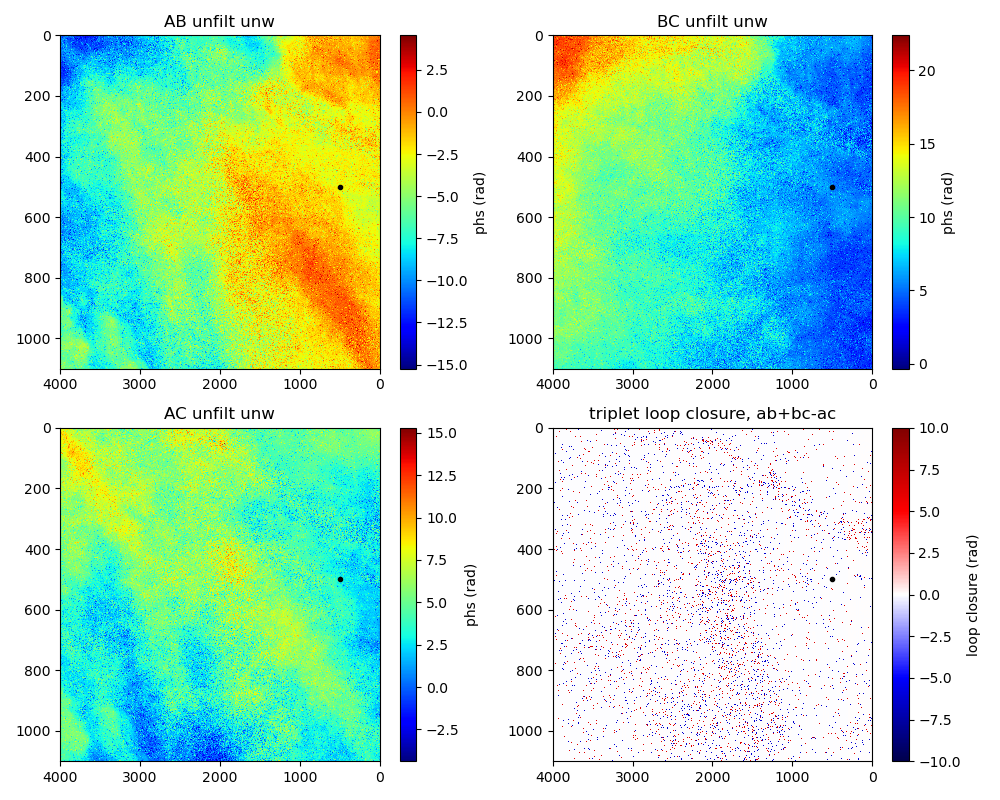

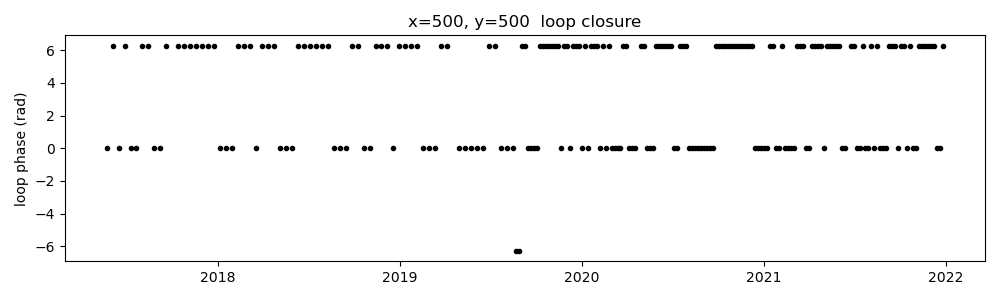

In [6]:
# index of triplet we want to plot
j = 5
# point of pixel to plot a time series for
x = 500
y = 500

# load the unfilt unw files specifically for chosen triplet
igramFileAB = igramsDir+dates[j]+'_'+dates[j+1]+'_unfilt.unw'
ds = gdal.Open(igramFileAB,gdal.GA_ReadOnly)
ab = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
igramFileBC = igramsDir+dates[j+1]+'_'+dates[j+2]+'_unfilt.unw'
ds = gdal.Open(igramFileBC,gdal.GA_ReadOnly)
bc = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
# skip1
igramFileAC = igramsDir+dates[j]+'_'+dates[j+2]+'_unfilt.unw'
ds = gdal.Open(igramFileAC,gdal.GA_ReadOnly)
ac = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)


# plot them
plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(ab,aspect='auto',interpolation='nearest',cmap='jet')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.colorbar(label='phs (rad)')
plt.plot(x,y,'k.')
plt.title('AB unfilt unw')
plt.subplot(2,2,2)
plt.imshow(bc,aspect='auto',interpolation='nearest',cmap='jet')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.colorbar(label='phs (rad)')
plt.title('BC unfilt unw')
plt.plot(x,y,'k.')
plt.subplot(2,2,3)
plt.imshow(ac,aspect='auto',interpolation='nearest',cmap='jet')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.colorbar(label='phs (rad)')
plt.title('AC unfilt unw')
plt.plot(x,y,'k.')
plt.subplot(2,2,4)
plt.imshow(trips[j],aspect='auto',interpolation='nearest',cmap='seismic',vmin=-10,vmax=10)
#plt.colorbar(orientation='vertical',pad=0.02,label='TPC (rad)')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.colorbar(label='loop closure (rad)')
#plt.xticks([]); plt.yticks([])
plt.title('triplet loop closure, ab+bc-ac')
plt.plot(x,y,'k.')
plt.show()

plt.figure(figsize=(10,3),tight_layout=True)
plt.plot(trip_dates,trips[:,x,y],'k.')
plt.ylabel('loop phase (rad)')
plt.title('x='+str(x)+', y='+str(y)+'  loop closure')
plt.show()

sum the triplet values over the igram axis (cumulative triplet phase values)

In [7]:
cumTrips = np.sum(trips,axis=0)

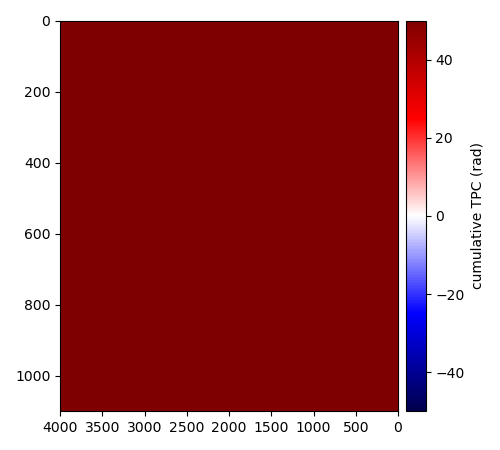

In [8]:
plt.figure(figsize=(5,4.5),tight_layout=True)
plt.imshow(cumTrips,aspect='auto',interpolation='nearest',cmap='seismic',vmin=-50,vmax=50)
plt.colorbar(orientation='vertical',pad=0.02,label='cumulative TPC (rad)')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.show()